# Part 1: Symbol Recognizer v2
Re-train the CNN to recognize a rotated symbol in a noisy image

In [1]:
from os import listdir, makedirs
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models
from PIL import Image, ImageDraw, ImageFont
from random import randrange
from IPython.display import display

In [2]:
WIDTH       =   200
HEIGHT      =   100
MINX        =    20
MINY        =    20
MAXX        =    WIDTH-60
MAXY        =    HEIGHT-60
MINSIZE     =    24
MAXSIZE     =    48
NUMCHARS    =     4 # 4 character CAPTCHA
SYMBOL_SIZE =    50
SYMBOL_SET  =    "0123456789"
NUM_SYMBOLS =    len(SYMBOL_SET)
FONTS_DIR   =    '../fonts'

In [3]:
# Helper functions
def onehot(x):
    b = np.zeros(NUM_SYMBOLS)
    b[x] = 1
    return b

def draw_box(image, box):
    canvas = ImageDraw.Draw(image)
    canvas.rectangle(box, outline=(255,0,0), width=1)
    display(image)

In [4]:
def generate_symbol(return_image=False):
    fonts = [i for i in listdir(FONTS_DIR) if i.endswith('.ttf')]
    while True:
        # Draw a base white canvas
        img = Image.new('RGB', (WIDTH, HEIGHT), color = (255,255,255))
        canvas = ImageDraw.Draw(img)

        # Add Noise by adding random lines
        for _ in range(randrange(5, 10)):  # Number of lines
            x1, y1 = randrange(WIDTH), randrange(HEIGHT)
            x2, y2 = randrange(WIDTH), randrange(HEIGHT)
            line_color = tuple(randrange(50, 150) for _ in range(3))  # Grayish lines
            canvas.line((x1, y1, x2, y2), fill=line_color, width=randrange(1,5))

        # Character selection
        font_size = randrange(MINSIZE, MAXSIZE)
        font = ImageFont.truetype(f'{FONTS_DIR}/{fonts[randrange(len(fonts))]}', font_size)
        character = SYMBOL_SET[randrange(NUM_SYMBOLS)]

        # Character rendering
        char_img = Image.new('RGBA', (100, 100), (255, 255, 255, 0))
        char_draw = ImageDraw.Draw(char_img)
        char_draw.text((25, 25), character, font=font, fill=(0, 0, 0))
        angle = randrange(-70, 70)
        rotated_char = char_img.rotate(angle, resample=Image.BICUBIC, expand=False)
        
        # Extract bounding box from alpha channel to locate the drawn text
        alpha = rotated_char.getchannel('A')
        bbox = alpha.getbbox()
        char_crop = rotated_char.crop(bbox)

        # Center paste into the base canvas
        composite_layer = Image.new('RGBA', (WIDTH, HEIGHT), (255, 255, 255, 0))
        paste_x = (WIDTH - char_crop.width) // 2
        paste_y = (HEIGHT - char_crop.height) // 2
        composite_layer.paste(char_crop, (paste_x, paste_y))
        
        # Merge with the base canvas
        img = Image.alpha_composite(img.convert('RGBA'), composite_layer).convert('RGB')
        coords = (paste_x, paste_y, paste_x + char_crop.width, paste_y + char_crop.height)
        x = np.array(img.crop(coords).resize((SYMBOL_SIZE, SYMBOL_SIZE)).convert('RGB')).astype(np.float32) / 255.0
        y = onehot(int(character))
        
        if return_image:
            yield x, y, coords, img
        else:
            yield x, y

Character: 6


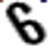

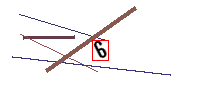

In [5]:
x, y, coords, image = next(generate_symbol(return_image=True))
print("Character:", int(y.argmax()))
x_img = Image.fromarray((x * 255).astype(np.uint8))
display(x_img)
draw_box(image, coords)

In [6]:
symbol_dataset = tf.data.Dataset.from_generator(generate_symbol,
            output_signature=(tf.TensorSpec(shape=(SYMBOL_SIZE, SYMBOL_SIZE, 3), dtype=tf.float32),
                             tf.TensorSpec(shape=(NUM_SYMBOLS,), dtype=tf.float32)
                             ))
symbol_dataset = symbol_dataset.batch(batch_size=32)

In [7]:
PATH = 'logs/symbol_recognizer/'
log_dir = PATH + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# # Model Architecture
# data_augmentation = models.Sequential([
#     layers.RandomZoom(0.2, 0.2),
#     layers.RandomTranslation(0.2, 0.2),
#     layers.RandomRotation(0.1),
#     layers.RandomContrast(0.2)
# ])

# sym_model = models.Sequential()
# sym_model.add(layers.Input(shape=(SYMBOL_SIZE, SYMBOL_SIZE, 3)))
# sym_model.add(data_augmentation)

# # Convolutional feature extractor
# for filters in [32, 64, 128]:
#     sym_model.add(layers.Conv2D(filters, (3, 3), padding='same'))
#     sym_model.add(layers.BatchNormalization())
#     sym_model.add(layers.Activation('relu'))
#     sym_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# # Classification head
# sym_model.add(layers.Flatten())
# sym_model.add(layers.Dense(128, activation='relu'))
# sym_model.add(layers.Dropout(0.3))
# sym_model.add(layers.Dense(NUM_SYMBOLS, activation='softmax'))

# sym_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
# sym_history = sym_model.fit(symbol_dataset, epochs=200, steps_per_epoch=500, callbacks=[tensorboard_callback])
# makedirs("../models", exist_ok=True)
# sym_model.save("../models/Symbol_Recognizer-200epochs.keras")
# sym_model.summary()

In [8]:
# Load the original model
sym_model = tf.keras.models.load_model("../models/Symbol_Recognizer-100epochs.keras")
sym_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 50, 50, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 32)          │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 9, 9, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,164 (629.55 KB)

 Trainable params: 161,162 (629.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [9]:
# Continue training with new dataset
sym_history = sym_model.fit(symbol_dataset, initial_epoch=100, epochs=200, steps_per_epoch=500, callbacks=[tensorboard_callback])
sym_model.save("../models/Symbol_Recognizer-200epochs.keras")

Epoch 101/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 49s 95ms/step - accuracy: 0.3157 - loss: 2.3442
Epoch 102/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 48s 95ms/step - accuracy: 0.5178 - loss: 1.4065
Epoch 103/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 95ms/step - accuracy: 0.6045 - loss: 1.1477
Epoch 104/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - accuracy: 0.6489 - loss: 1.0258
Epoch 105/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - accuracy: 0.6847 - loss: 0.9278
Epoch 106/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - accuracy: 0.7047 - loss: 0.8589
Epoch 107/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.7254 - loss: 0.7979
Epoch 108/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.7459 - loss: 0.7504
Epoch 109/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.7601 - loss: 0.7056
Epoch 110/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.7607 - loss: 0.6902
Epoch 111/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 91ms/step - accuracy: 0.7905 - loss: 0.6254

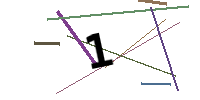

Prediction: 1


In [10]:
x, y, coords, image = next(generate_symbol(return_image=True))
y_pred = sym_model.predict(np.expand_dims(x, axis=0), verbose=False)
display(image)
print("Prediction:", int(y_pred.argmax()))

In [11]:
# Evaluate the Symbol Recognizer
test_size = 1000
count = 0
for i in range(test_size):
    x, y, coords, image = next(generate_symbol(return_image=True))
    y_pred = sym_model.predict(np.expand_dims(x, axis=0), verbose=False)
    if y.argmax() != y_pred.argmax():
        count += 1
        # print("Truth:", y.argmax())
        # print("Predicted:", y_pred.argmax())
        # display(image)
print("Accuracy:", (test_size-count)*100/test_size)

Accuracy: 99.1
